In [1]:
import os, re, json, numpy as np, pandas as pd
from typing import List, Dict, Iterable
from dataclasses import dataclass
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# ---------------------- PATHS ----------------------
PATH_SONGS  = 'SpotifyFeatures.csv'
PATH_MOVIES = 'tmdb_5000_movies.csv'
PATH_BOOKS  = 'books.csv'
TOPN_EACH   = 7
LOG = True

def log(msg: str):
    if LOG: print(f"[INFO] {msg}")

# ---------------------- UTILS ----------------------
def normalize_colnames(df: pd.DataFrame) -> pd.DataFrame:
    df.columns = [re.sub(r"\s+", "_", str(c)).strip().lower() for c in df.columns]
    return df

def pick_first_present(cands: List[str], columns, default=None):
    for c in cands:
        if c in columns: return c
    return default

def clip01(x):
    try: return max(0.0, min(1.0, float(x)))
    except: return 0.5

def coalesce_col(df: pd.DataFrame, col: str, default: str = "") -> pd.Series:
    """
    Always return a Series (len=len(df)) for column `col`.
    If the column doesn't exist, return a Series filled with `default`.
    """
    if col in df.columns:
        return df[col].fillna(default).astype(str)
    return pd.Series([default] * len(df), index=df.index, dtype="object")

# ---------------------- ROBUST CSV READER ----------------------
def read_csv_robust(path: str) -> pd.DataFrame:
    last_err = None
    for enc in ("utf-8", "utf-8-sig", "latin-1"):
        try:
            df = pd.read_csv(path, encoding=enc)
            log(f"Loaded {os.path.basename(path)} with encoding={enc}, engine=C")
            return df
        except Exception as e:
            last_err = e
        try:
            df = pd.read_csv(path, encoding=enc, engine="python",
                             sep=",", on_bad_lines="skip",
                             quotechar='"', escapechar="\\")
            log(f"Loaded {os.path.basename(path)} with encoding={enc}, engine=python (skipped bad lines)")
            return df
        except Exception as e:
            last_err = e
        try:
            df = pd.read_csv(path, encoding=enc, engine="python",
                             sep=None, on_bad_lines="skip")
            log(f"Loaded {os.path.basename(path)} with encoding={enc}, sep=auto (skipped bad lines)")
            return df
        except Exception as e:
            last_err = e
    raise last_err

# ---------------------- MOODS ----------------------
MOODS = ["happy","sad","calm","angry","anxious","energetic","romantic","thoughtful","bored","neutral"]
UPLIFT = {
    "sad":"happy","angry":"calm","anxious":"calm","bored":"energetic",
    "thoughtful":"happy","neutral":"happy","romantic":"romantic",
    "calm":"happy","energetic":"happy","happy":"happy"
}
MOOD_WORDS = {
    "happy":["happy","joy","excited","great","awesome","delighted","glad","cheerful"],
    "sad":["sad","down","unhappy","depressed","low","blue"],
    "calm":["calm","peaceful","relaxed","serene","soothing"],
    "angry":["angry","mad","furious","rage","annoyed","irritated"],
    "anxious":["anxious","nervous","worried","stressed","tense"],
    "energetic":["energetic","pumped","hype","workout","dance","party"],
    "romantic":["romantic","love","date","valentine","sweet"],
    "thoughtful":["thoughtful","reflective","introspective","melancholy"],
    "bored":["bored","meh","dull","monotony"],
    "neutral":["ok","fine","normal","average","neutral"]
}

def detect_mood(text: str) -> str:
    if not isinstance(text, str) or not text.strip(): return "neutral"
    t = text.lower()
    scores = {m:0 for m in MOODS}
    for mood, words in MOOD_WORDS.items():
        for w in words: scores[mood] += t.count(w)
    m = max(scores, key=scores.get)
    return m if scores[m] > 0 else "neutral"

def uplift_target(mood: str) -> str:
    return UPLIFT.get(mood, "happy")

# ---------------------- MOOD TAGGING ----------------------
def map_spotify_row(row):
    v,e,d = clip01(row.get("valence",0.5)), clip01(row.get("energy",0.5)), clip01(row.get("danceability",0.5))
    if v>=.6 and e>=.6: return "energetic","happy"
    if v>=.6 and e< .6: return "happy","calm"
    if v< .4 and e< .5: return "sad","thoughtful"
    if v< .4 and e>=.5: return "angry","anxious"
    if d>.6 and v>=.5: return "energetic","happy"
    return "calm","neutral"

DOMAIN_KWS = {
    "happy":["feel-good","heartwarming","comedy","joy","uplifting"],
    "sad":["tragic","heartbreak","loss","drama","tearjerker"],
    "calm":["soothing","gentle","nature","quiet","meditative"],
    "angry":["revenge","vengeance","rage","brutal","violent","Frustrated"],
    "anxious":["thriller","anxiety","tense","suspense","stressful"],
    "energetic":["action","adventure","fast-paced","high-octane"],
    "romantic":["romance","romantic","love story","affair"],
    "thoughtful":["philosophy","reflective","introspective","literary"],
    "bored":["monotonous"],
    "neutral":[]
}
def text_to_mood(text: str) -> str:
    t = (text or "").lower()
    votes = {m:0 for m in MOODS}
    for mood,kws in DOMAIN_KWS.items():
        for kw in kws:
            if kw in t: votes[mood]+=1
    m = max(votes, key=votes.get)
    return m if votes[m] > 0 else "neutral"

# ---------------------- LOADERS ----------------------
def load_spotify(path=PATH_SONGS):
    if not os.path.exists(path): return pd.DataFrame()
    df = read_csv_robust(path); df = normalize_colnames(df)
    tcol = pick_first_present(["track_name","name","title"], df.columns)
    acol = pick_first_present(["artists","artist","artist_name"], df.columns)
    if not tcol or not acol:
        obj = [c for c in df.columns if df[c].dtype == object]
        if len(obj) >= 2: tcol, acol = obj[0], obj[1]
        else: return pd.DataFrame()
    keep = [c for c in [tcol,acol,"valence","energy","danceability","tempo","acousticness","instrumentalness","speechiness"] if c in df.columns]
    df = df[keep].copy()
    df.rename(columns={tcol:"title", acol:"artist"}, inplace=True)
    for c in ["valence","energy","danceability","tempo","acousticness","instrumentalness","speechiness"]:
        if c in df.columns: df[c] = pd.to_numeric(df[c], errors="coerce")
    if not df.empty:
        df["mood_primary"], df["mood_secondary"] = zip(*df.apply(map_spotify_row, axis=1))
    df["domain"] = "song"
    return df.reset_index(drop=True)

def load_movies(path=PATH_MOVIES):
    if not os.path.exists(path): return pd.DataFrame()
    df = read_csv_robust(path); df = normalize_colnames(df)
    keep = [c for c in ["title","overview","genres","tagline","vote_average","vote_count","popularity"] if c in df.columns]
    if not keep: return pd.DataFrame()
    df = df[keep].copy()
    df["text_blob"] = (
        coalesce_col(df, "title") + ". " +
        coalesce_col(df, "tagline") + ". " +
        coalesce_col(df, "overview") + ". " +
        coalesce_col(df, "genres")
    )
    df["mood_primary"] = df["text_blob"].apply(text_to_mood)
    df["mood_secondary"] = "neutral"; df["domain"] = "movie"
    for c in ["vote_average","vote_count","popularity"]:
        if c in df.columns: df[c] = pd.to_numeric(df[c], errors="coerce")
    return df.reset_index(drop=True)

def load_books(path=PATH_BOOKS):
    if not os.path.exists(path): return pd.DataFrame()
    df = read_csv_robust(path); df = normalize_colnames(df)

    t = pick_first_present(["title","book_title","booktitle","name"], df.columns)
    a = pick_first_present(["authors","author","book_author"], df.columns)
    d = pick_first_present(["description","summary","overview","blurb"], df.columns)
    g = pick_first_present(["genres","shelves","categories"], df.columns)

    keep = [c for c in [t,a,d,g] if c]
    if not keep: keep = list(df.columns[:4])
    df = df[keep].copy()

    if t: df.rename(columns={t:"title"}, inplace=True)
    if a: df.rename(columns={a:"authors"}, inplace=True)
    if d: df.rename(columns={d:"description"}, inplace=True)
    if g: df.rename(columns={g:"genres"}, inplace=True)

    df["text_blob"] = (
        coalesce_col(df, "title") + ". " +
        coalesce_col(df, "description") + ". " +
        coalesce_col(df, "genres")
    )
    df["mood_primary"] = df["text_blob"].apply(text_to_mood)
    df["mood_secondary"] = "neutral"; df["domain"] = "book"
    return df.reset_index(drop=True)

# ---------------------- FEATURES ----------------------
def build_song_features(df):
    feats = ["valence","energy","danceability","tempo","acousticness","instrumentalness","speechiness"]
    keep = [c for c in feats if c in df.columns]
    if not keep: return np.zeros((len(df),1)), None, ["_dummy"]
    X = df[keep].fillna(df[keep].median(numeric_only=True))
    scaler = StandardScaler(); Xn = scaler.fit_transform(X)
    return Xn, scaler, keep

def build_text_features(texts):
    vec = TfidfVectorizer(max_features=20000, stop_words="english")
    X = vec.fit_transform(texts)
    return X, vec

# ---------------------- RECOMMENDER WRAPPERS ----------------------
@dataclass
class DomainRecommender:
    domain: str
    model: any
    feature_matrix: any
    meta_df: pd.DataFrame
    aux: dict

def fit_song_recommender(df):
    if df.empty: return DomainRecommender("song", None, None, df, {})
    Xn, scaler, cols = build_song_features(df)
    knn = NearestNeighbors(n_neighbors=50, metric="cosine").fit(Xn)
    return DomainRecommender("song", knn, Xn, df, {"scaler":scaler, "feat_cols":cols})

def fit_text_recommender(df, domain):
    if df.empty: return DomainRecommender(domain, None, None, df, {})
    X, vec = build_text_features(df["text_blob"].fillna("").tolist())
    knn = NearestNeighbors(n_neighbors=50, metric="cosine").fit(X)
    return DomainRecommender(domain, knn, X, df, {"vectorizer":vec})

# ---------------------- RETRIEVAL ----------------------
def mood_mask(df, target):
    return (df["mood_primary"]==target) | (df["mood_secondary"]==target)

def pop_score(df, cols):
    parts=[]
    for c in cols:
        if c in df.columns:
            x = pd.to_numeric(df[c], errors="coerce")
            parts.append(x.fillna(x.median()).values.reshape(-1,1))
    if not parts: return np.zeros((len(df),))
    M = np.hstack(parts)
    return MinMaxScaler().fit_transform(M).mean(axis=1)

def topN(rec, target, N=10):
    df = rec.meta_df.copy()
    if df.empty or rec.model is None: return df.iloc[0:0]
    mask = mood_mask(df, target)
    if not mask.any():
        df["pop"] = pop_score(df, ["vote_average","vote_count","popularity"])
        return df.sort_values("pop", ascending=False).head(N)
    sub = df[mask].copy()
    sub["pop"] = pop_score(sub, ["vote_average","vote_count","popularity"])
    rng = np.random.default_rng(42)
    sub["pop_jitter"] = sub["pop"] + rng.normal(0, 0.01, len(sub))
    return sub.sort_values("pop_jitter", ascending=False).head(N)

# ---------------------- ORCHESTRATOR ----------------------
class CrossDomainUpliftRecommender:
    def __init__(self, p1, p2, p3):
        self.songs  = load_spotify(p1)
        self.movies = load_movies(p2)
        self.books  = load_books(p3)
        self.rec_song  = fit_song_recommender(self.songs)
        self.rec_movie = fit_text_recommender(self.movies, "movie")
        self.rec_book  = fit_text_recommender(self.books, "book")

    def recommend(self, text: str, topn=TOPN_EACH):
        mood = detect_mood(text); target = uplift_target(mood)
        songs  = topN(self.rec_song,  target, topn)
        movies = topN(self.rec_movie, target, topn)
        books  = topN(self.rec_book,  target, topn)
        out = {"input_text": text, "detected_mood": mood, "uplift_target_mood": target,
               "recommendations": {"songs": [], "movies": [], "books": []}}
        for _, r in songs.iterrows():
            out["recommendations"]["songs"].append({"title": r.get("title",""), "artist": r.get("artist",""), "mood": r.get("mood_primary","")})
        for _, r in movies.iterrows():
            out["recommendations"]["movies"].append({"title": r.get("title",""), "mood": r.get("mood_primary","")})
        for _, r in books.iterrows():
            out["recommendations"]["books"].append({"title": r.get("title",""), "authors": r.get("authors",""), "mood": r.get("mood_primary","")})
        return out

# ================== EVALUATION MODULE ==================
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from typing import Iterable

def _relevance(row, target):
    if row.get("mood_primary") == target: return 1.0
    if row.get("mood_secondary") == target: return 0.5
    return 0.0

def precision_at_k(rels, k):
    k = min(k, len(rels))
    return float(np.sum(rels[:k])) / k if k > 0 else 0.0

def dcg_at_k(rels, k):
    rels = rels[:k]
    return np.sum([(rels[i] / np.log2(i + 2)) for i in range(len(rels))])

def ndcg_at_k(rels, k):
    best = sorted(rels, reverse=True)
    ideal = dcg_at_k(best, k)
    if ideal == 0: return 0.0
    return dcg_at_k(rels, k) / ideal

def popularity_percentile(vec):
    if len(vec) == 0: return 0.0
    ranks = pd.Series(vec).rank(pct=True).values
    return float(np.mean(ranks))

def intra_list_diversity(texts):
    if len(texts) <= 1: return 0.0
    vec = TfidfVectorizer(max_features=3000, stop_words="english")
    X = vec.fit_transform(texts)
    S = cosine_similarity(X)
    n = S.shape[0]
    return float(1.0 - ((S.sum() - n) / (n*(n-1))))

def eval_one_domain(df_all, rec_rows, target, k=10):
    if len(rec_rows) == 0:
        return {"P@K":0.0,"nDCG@K":0.0,"Coverage":0.0,"PopBias":0.0,"Diversity":0.0}

    rec_df = pd.DataFrame(rec_rows)
    if "title" in df_all.columns and "title" in rec_df.columns:
        j = rec_df.merge(df_all, on="title", how="left", suffixes=("","_cat"))
    else:
        j = rec_df.copy()

    rels = j.apply(lambda r: _relevance(r, target), axis=1).values
    p_at_k = precision_at_k(rels, k)
    ndcg = ndcg_at_k(rels, k)
    cov = len(j["title"].dropna().unique()) / max(1, len(df_all))

    pop_cols = [c for c in ["vote_count","popularity"] if c in df_all.columns]
    if pop_cols:
        pop_vec = pd.to_numeric(j[pop_cols[0]], errors="coerce").fillna(0).values
        pop_bias = popularity_percentile(pop_vec)
    else:
        pop_bias = 0.0

    texts = j["title"].astype(str).tolist() if "title" in j.columns else []
    div = intra_list_diversity(texts) if texts else 0.0

    return {"P@K":p_at_k, "nDCG@K":ndcg, "Coverage":cov, "PopBias":pop_bias, "Diversity":div}

def evaluate_system(system, queries: Iterable[str], k=10, topn_each=10):
    metrics = {d: [] for d in ["song","movie","book"]}
    for q in queries:
        mood = detect_mood(q)
        target = uplift_target(mood)
        res = system.recommend(q, topn=topn_each)

        m_song  = eval_one_domain(system.songs,  res["recommendations"]["songs"],  target, k)
        m_movie = eval_one_domain(system.movies, res["recommendations"]["movies"], target, k)
        m_book  = eval_one_domain(system.books,  res["recommendations"]["books"],  target, k)

        metrics["song"].append(m_song)
        metrics["movie"].append(m_movie)
        metrics["book"].append(m_book)

    def _agg(lst):
        if not lst: return {}
        keys = lst[0].keys()
        return {k: float(np.mean([x[k] for x in lst])) for k in keys}

    out = {d: _agg(metrics[d]) for d in metrics}
    keys = list(next(iter(out.values())).keys()) if out else []
    overall = {k: float(np.mean([out[d][k] for d in out])) for k in keys}
    return {"per_domain": out, "overall": overall}
# ================== /EVALUATION MODULE ==================


[INFO] Loaded SpotifyFeatures.csv with encoding=utf-8, engine=C
[INFO] Loaded tmdb_5000_movies.csv with encoding=utf-8, engine=C
[INFO] Loaded books.csv with encoding=utf-8, engine=python (skipped bad lines)
Cross-Domain Uplift Recommender — Evaluation

Per-domain metrics:
        P@K  nDCG@K  Coverage  PopBias  Diversity
song  0.829   0.828     0.000    0.000      0.874
movie 1.000   1.000     0.001    0.571      1.014
book  1.000   1.000     0.001    0.000      0.939

Overall:
P@K         0.943
nDCG@K      0.943
Coverage    0.001
PopBias     0.190
Diversity   0.942


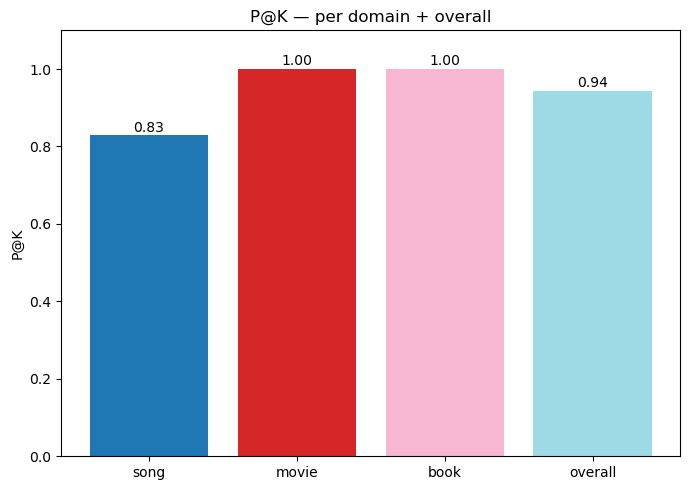

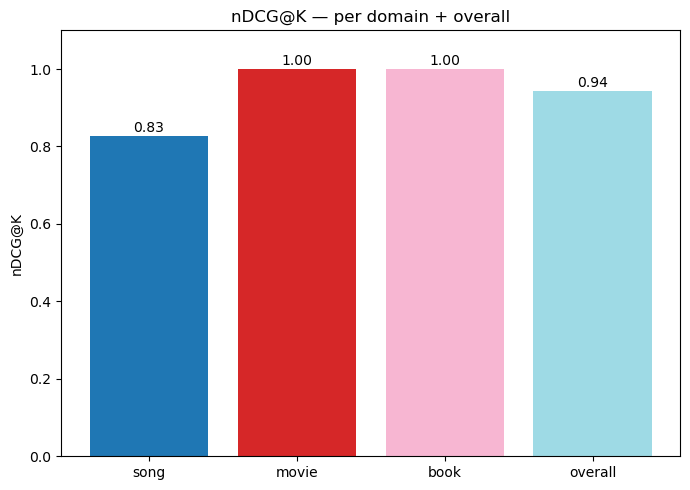

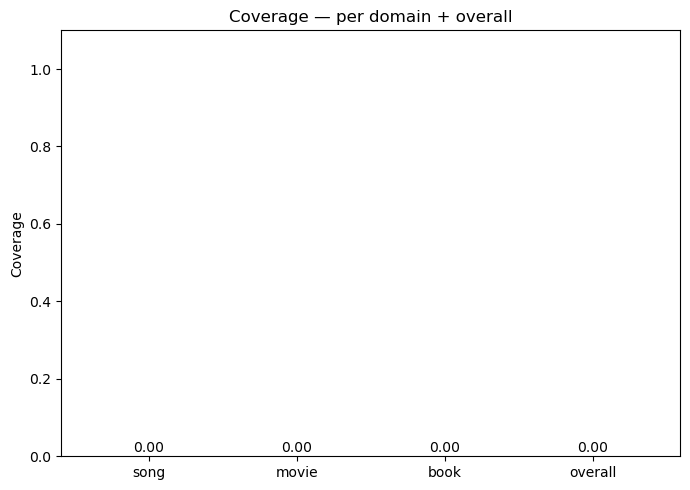

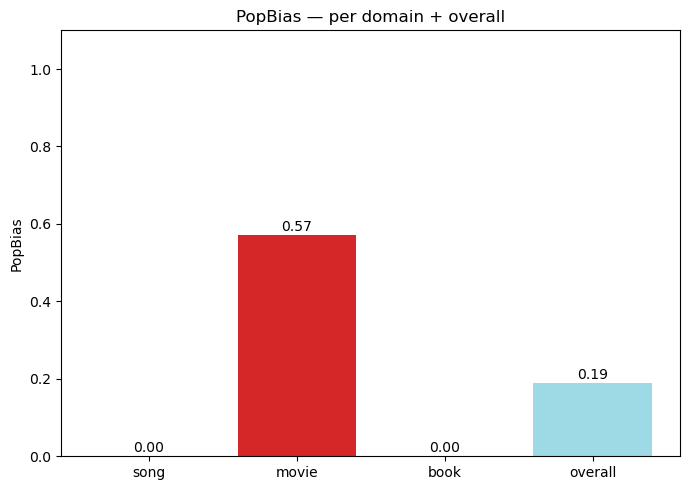

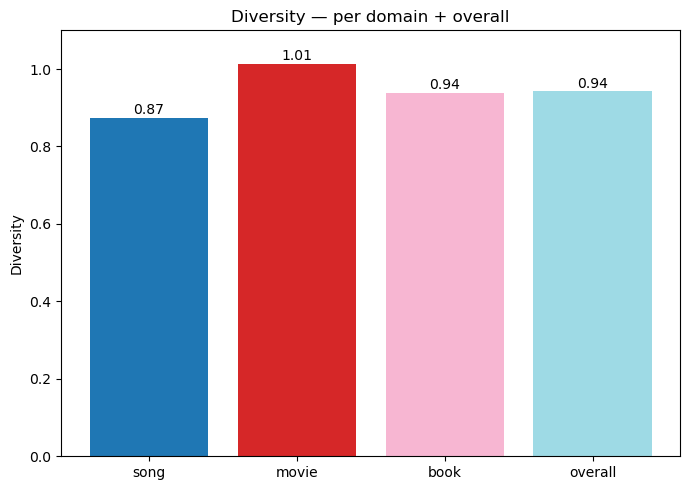

/var/folders/47/8rljqbkx5417r2rgz6_yyr100000gn/T/ipykernel_15838/76515616.py:89: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10")


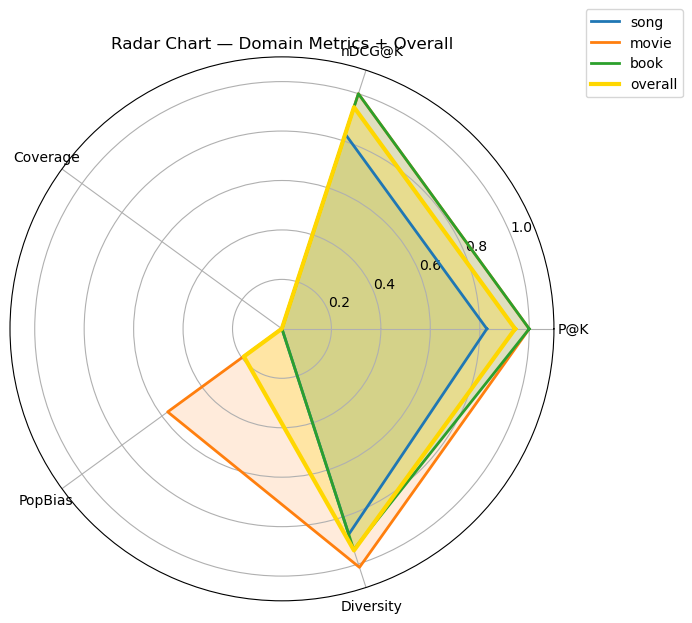

In [2]:
recsys = CrossDomainUpliftRecommender(PATH_SONGS, PATH_MOVIES, PATH_BOOKS)
queries = [
    "Feeling stressed and anxious; need something calming",
    "I'm sad and low today, want something uplifting",
    "Angry and frustrated with work",
    "Bored and need energetic recommendations",
    "Calm mood; looking for peaceful picks"
]
report = evaluate_system(recsys, queries, k=7, topn_each=7)

def print_eval_table(report, title=None):
    """Pretty-print the evaluation dict without altering the rest of your code."""
    if title:
        print(title)

    per_domain = report.get("per_domain", {})
    overall = report.get("overall", {})

    # Per-domain table
    if per_domain:
        df = pd.DataFrame(per_domain).T  # rows: domains, cols: metrics
        # Ensure consistent numeric formatting
        with pd.option_context('display.float_format', lambda v: f"{v:.3f}"):
            print("\nPer-domain metrics:")
            print(df.fillna(0.0).to_string())

    # Overall row
    if overall:
        s = pd.Series(overall)
        with pd.option_context('display.float_format', lambda v: f"{v:.3f}"):
            print("\nOverall:")
            print(s.fillna(0.0).to_string())
            
def plot_bars(report):
    import matplotlib.pyplot as plt
    import numpy as np
    import random

    per = report.get("per_domain", {})
    overall = report.get("overall", {})
    metrics = ["P@K", "nDCG@K", "Coverage", "PopBias", "Diversity"]

    domains = [d for d in ["song", "movie", "book"] if d in per]

    for m in metrics:
        domain_vals = [float(per.get(d, {}).get(m, 0.0)) for d in domains]
        overall_val = float(overall.get(m, 0.0))

        colors = plt.cm.tab20(np.linspace(0, 1, len(domain_vals) + 1))

        plt.figure(figsize=(7, 5))

        # Domain bars
        plt.bar(domains, domain_vals, color=colors[:len(domain_vals)], label="Domains")

        # Overall metric bar
        plt.bar("overall", overall_val, color=colors[-1], label="Overall")

        # Labels on bar tops
        for idx, v in enumerate(domain_vals):
            plt.text(idx, v + 0.01, f"{v:.2f}", ha="center")
        plt.text(len(domain_vals), overall_val + 0.01, f"{overall_val:.2f}", ha="center")

        plt.title(f"{m} — per domain + overall")
        plt.ylabel(m)

        plt.ylim(0, 1.1)
        plt.tight_layout()
        plt.show()

        
def plot_radar(report):
    import matplotlib.pyplot as plt
    import numpy as np

    per = report.get("per_domain", {})
    overall = report.get("overall", {})
    metrics = ["P@K", "nDCG@K", "Coverage", "PopBias", "Diversity"]
    domains = [d for d in ["song", "movie", "book"] if d in per]

    labels = metrics
    num_vars = len(labels)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]

    plt.figure(figsize=(7, 7))
    ax = plt.subplot(111, polar=True)

    cmap = plt.cm.get_cmap("tab10")

    # Domain polygons
    for idx, d in enumerate(domains):
        vals = [float(per[d].get(m, 0.0)) for m in labels]
        vals += vals[:1]
        ax.plot(angles, vals, color=cmap(idx), linewidth=2, label=d)
        ax.fill(angles, vals, color=cmap(idx), alpha=0.15)

    # Overall polygon
    overall_vals = [float(overall.get(m, 0.0)) for m in labels]
    overall_vals += overall_vals[:1]
    ax.plot(angles, overall_vals, color="gold", linewidth=3, label="overall")
    ax.fill(angles, overall_vals, color="gold", alpha=0.25)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)
    ax.set_ylim(0, 1.1)
    plt.title("Radar Chart — Domain Metrics + Overall")
    plt.legend(loc="upper right", bbox_to_anchor=(1.25, 1.1))
    plt.tight_layout()
    plt.show()

print_eval_table(report, title="Cross-Domain Uplift Recommender — Evaluation")
plot_bars(report)
plot_radar(report)
plt.show()

In [3]:
#P@K = precision (Measures accuracy of the top recommendations.)
#nDCG@K = Normalized Discounted Cumulative Gain (Balances relevance and ordering.)
#Coverage = exploration 
# PopBias = popularity bias (Measures how strongly your system favors popular items)
# Diversity = checks how differently items are recommended .